In [1]:
!pip install numpy > log
!pip install matplotlib > log
!pip install seaborn > log
!pip install scikit-image > log
!pip install imageio > log

You are using pip version 18.1, however version 20.3b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.3b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.3b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.3b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.3b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Part 1 : The base algorithm

In [3]:

def one_iter_propagate(wave, adj):
    padded = np.pad(
                    wave, ((0, 0), (1, 1), (1, 1)), mode="constant", constant_values=True
                )
    update = dict()
    for d in adj:
        dx, dy = d
        current = padded[
            :, (dx + 1):(wave.shape[1] + dx + 1), (dy + 1):(wave.shape[2] + dy + 1)  
        ]
        
        update[d] = (adj[d] @ current.reshape(current.shape[0], -1)).reshape(current.shape)
        
    for d in adj:
        wave *= update[d]
        
    np.clip(wave, 0, 1, out=wave)

        
def propagate(wave, adj):
    count = 0
    last_count = 0
    while last_count != wave.sum():
        last_count = wave.sum()
        one_iter_propagate(wave, adj)
        
        if (wave.sum(axis=0) == 0).any():
            plt.figure()
            show_state_map(wave)
            raise Exception("Contradiction found")
            
        count += 1
        
    return count

    

In [4]:
def show_state_map(wave, colors=None, legend=True, savefig=False, ax=None):
    
    state_size = wave.shape[0]
    colors = list(map(np.array, sns.color_palette("hls", state_size))) if not colors else colors
    
    if colors[0][0] > 1.0:
        colors = [np.array([c[0] / 255., c[1] / 255., c[2] / 255.]) for c in colors ]
    img = np.ones((wave.shape[1], wave.shape[2], 3))
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if sum(wave[:, i, j]) == 1:
                selected_color = np.argmax(wave[:, i, j])
                img[i, j, :] = colors[selected_color]
            else:
                img[i, j, :] = 1. / sum(wave[:, i, j]) * sum(colors[k] for k in range(state_size) if wave[k, i, j] == 1)
                
    patches = [mpatches.Patch(color=colors[i], label=f'Class {i}') for i in range(state_size)]
    mixed_color_patches = []#[mpatches.Patch(color=0.5 * colors[i] + 0.5 * colors[j], label=f'Class {i}+{j}') for i in range(state_size) for j in range(state_size) if i < j]
    
    if legend:
        plt.legend(handles=patches + mixed_color_patches, loc="lower right")
    
    if savefig:
        if not os.path.exists("./saved_figs"):
            os.mkdir("./saved_figs")
        index = (wave.shape[0] * wave.shape[1] * wave.shape[2]) - np.sum(wave)
        plt.savefig(f"./saved_figs/fig_{index}.png")
    else:
        if ax is None:
            plt.imshow(img)
        else:
            ax.imshow(img)
        

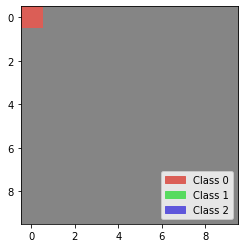

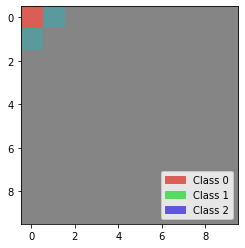

In [5]:
def test_propagate_iter():
    wave = np.ones((3, 10, 10))
    
    prop_base = np.array(
          [[0, 1, 1],
           [1, 0, 1], 
           [1, 1, 0], 
           ]
    )

    wave[:, 0, 0] = 0
    wave[0, 0, 0] = 1
    
    show_state_map(wave)

    adj = {(-1, 0): prop_base, (1, 0): prop_base, (0, -1): prop_base, (0, 1): prop_base}
    one_iter_propagate(wave, adj)
    
    plt.figure()
    show_state_map(wave)
    
    assert wave[:, 1, 0].sum() == 2
    
test_propagate_iter()

2


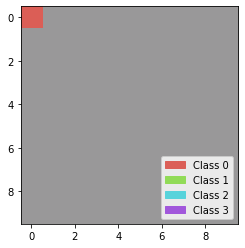

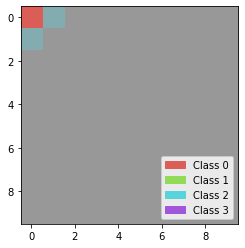

In [6]:
def test_full_propagate():
    wave = np.ones((4, 10, 10))
    
    prop_base = np.array(
          [[0, 1, 1, 1],
           [1, 0, 1, 1], 
           [1, 1, 0, 1], 
           [1, 1, 1, 0]]
    )
    
    wave[:, 0, 0] = 0
    wave[0, 0, 0] = 1
    
    show_state_map(wave)

    adj = {(-1, 0): prop_base, (1, 0): prop_base, (0, -1): prop_base, (0, 1): prop_base}
    count = propagate(wave, adj)
    
    plt.figure()
    show_state_map(wave)
    
    print(count)
    assert(count == 2)
    
test_full_propagate()

In [7]:
def select_location(wave):
    sub_index = np.where(np.sum(wave, axis=0) > 1, np.sum(wave, axis=0), 10000)
    index = np.argmin(sub_index)

    i = int(index / wave.shape[2])
    j = index % wave.shape[2]
    return i, j
    

def choose_state(wave, u, v):
    array = wave[:, u, v]
    indices = list(range(array.shape[0]))
    norm_array = array / sum(array)
    
    state_chosen = np.random.choice(indices, p=norm_array)
    wave[:, u, v] = 0
    wave[state_chosen, u, v] = 1

    

def wave_collapse_agorithm(wave, adj, show=True, save=False):
    iteration = 0
    
    while wave.sum() > wave.shape[1] * wave.shape[2]:
        if(iteration % 100 == 0 and show):
            plt.figure()
            show_state_map(wave)
            print(f"Iteration {iteration}")
            
        u, v = select_location(wave)
        choose_state(wave, u, v)
        
        if save:
            show_state_map(wave, savefig=True)
        
        propagate(wave, adj)
        iteration += 1
        
        if iteration > 100 * wave.shape[1] * wave.shape[2]:
            break
        
    

Iteration 0


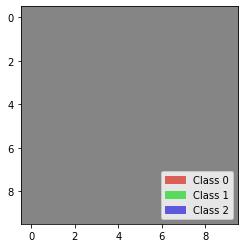

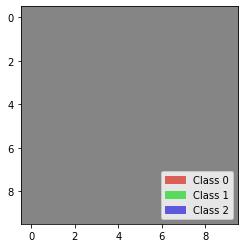

<Figure size 432x288 with 0 Axes>

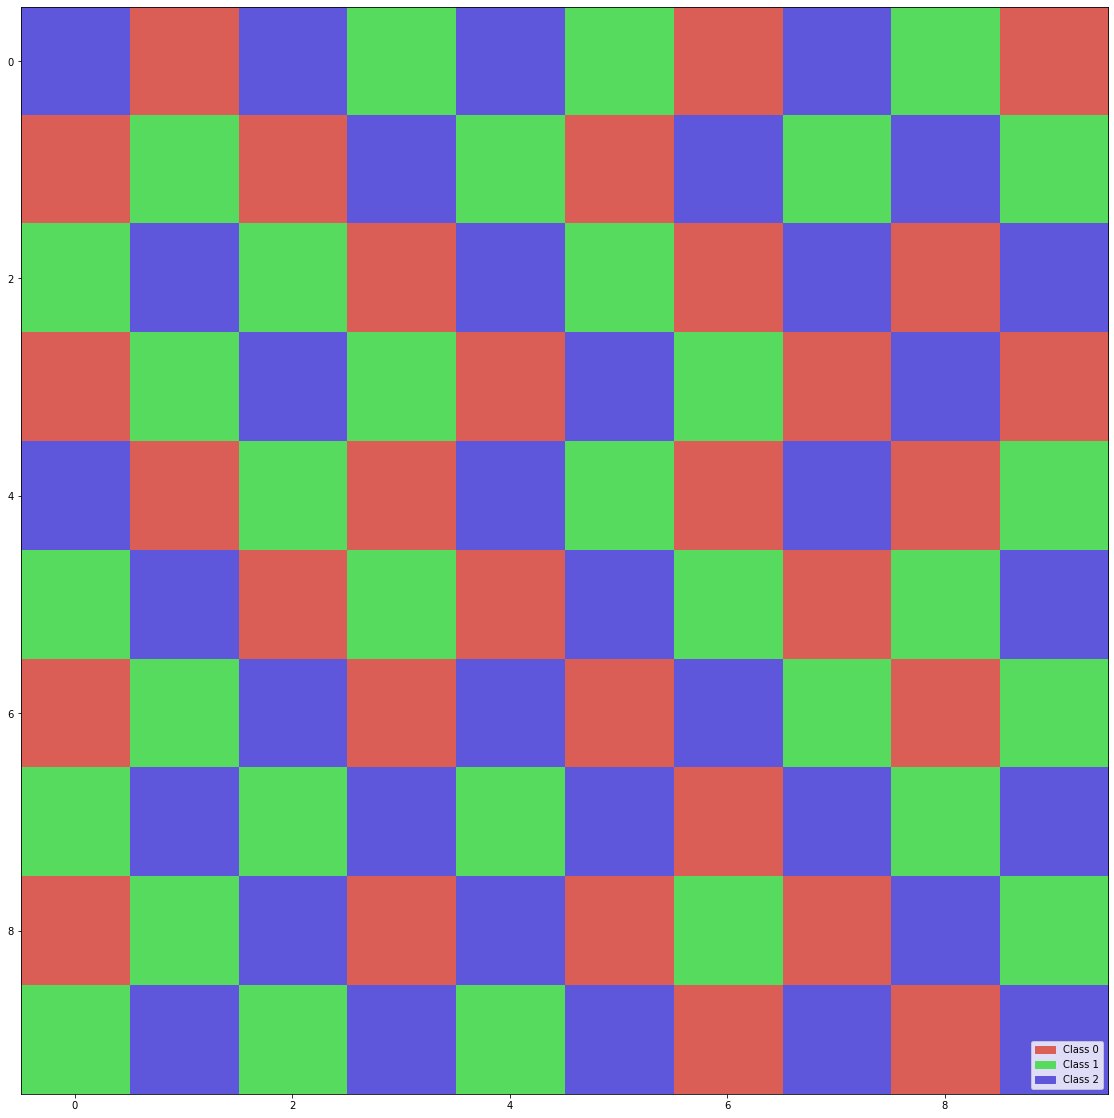

In [8]:
import os

def test_full_algorithm():
    wave = np.ones((3, 10, 10))
    
    prop_base = np.array(
          [[0, 1, 1],
           [1, 0, 1], 
           [1, 1, 0]])


    show_state_map(wave)

    adj = {(-1, 0): prop_base, (1, 0): prop_base, (0, -1): prop_base, (0, 1): prop_base}
    
    
    wave_collapse_agorithm(wave, adj, save=True)
    
    plt.figure()
    plt.figure(figsize=(20,20))
    show_state_map(wave)
    
test_full_algorithm()

### Small util to create a GIF to show the processing of the algorithm

In [9]:
from pathlib import Path
import imageio

image_path = Path('./saved_figs')
images = sorted(list(image_path.glob('*.png')), key=lambda x: float(x.name.split(".")[0].split("_")[1]))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
    
imageio.mimwrite('animated_from_images.gif', image_list)

In [10]:
image_path = Path('./saved_figs')

l = list(image_path.glob('*.png'))

l[0]

PosixPath('saved_figs/fig_183.0.png')

### Let's make it more visual : add a texture to each class

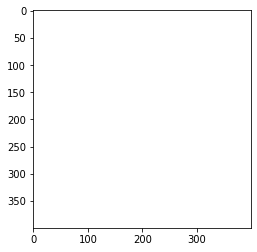

In [11]:
from skimage import io
from skimage import transform
import os


def ffrom_wave_to_patterns(wave, pattern_map, pattern_size):
    index_img = np.argmax(wave, axis=0)
    
    w = wave.shape[2] * pattern_size
    h = wave.shape[1] * pattern_size
    
    img = np.zeros((h, w, 4))
    
    for i in range(index_img.shape[0]):
        for j in range(index_img.shape[1]):
            index = int(index_img[i, j])
            pattern = pattern_map[index]
            img[i * pattern_size: (i+ 1) * pattern_size, j * pattern_size: (j+ 1) * pattern_size, :] = pattern
            
    plt.figure()
    plt.imshow(img)

wave = np.zeros((3, 10, 10))
wave[0, :, :] = 1
pattern_map = {0: 0 * np.ones((40, 40, 4)), 
               1: 0.5 * np.ones((40, 40, 4)), 
               2: 1 * np.ones((40, 40, 4))}
ffrom_wave_to_patterns(wave, pattern_map, 40)

# Part 2 alternate : vertical world

A set of colors can be stacked one upon another with strict order 

bottom = brown <= green <= blue = top

In [12]:

COLORS = [(96, 13, 42), (42, 96, 13), (13, 42, 96)]


# Bottom rule : yourself or the previous one
bottom_rule = np.array(
          [[1, 0, 0],
           [1, 1, 0], 
           [0, 1, 1]]
    )
# top rule : yourself or the next one
top_rule = np.array(
          [[1, 1, 0],
           [0, 1, 1], 
           [0, 0, 1]]
    )
# Side rule : anyone
side_rule = np.array(
          [[1, 1, 1],
           [1, 1, 1], 
           [1, 1, 1]]
    )


adj = {(-1, 0): bottom_rule, (1, 0): top_rule, (0, -1): side_rule, (0, 1): side_rule}


Iteration 0


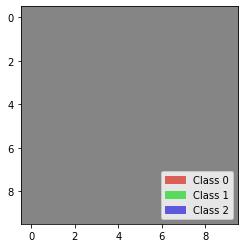

<Figure size 432x288 with 0 Axes>

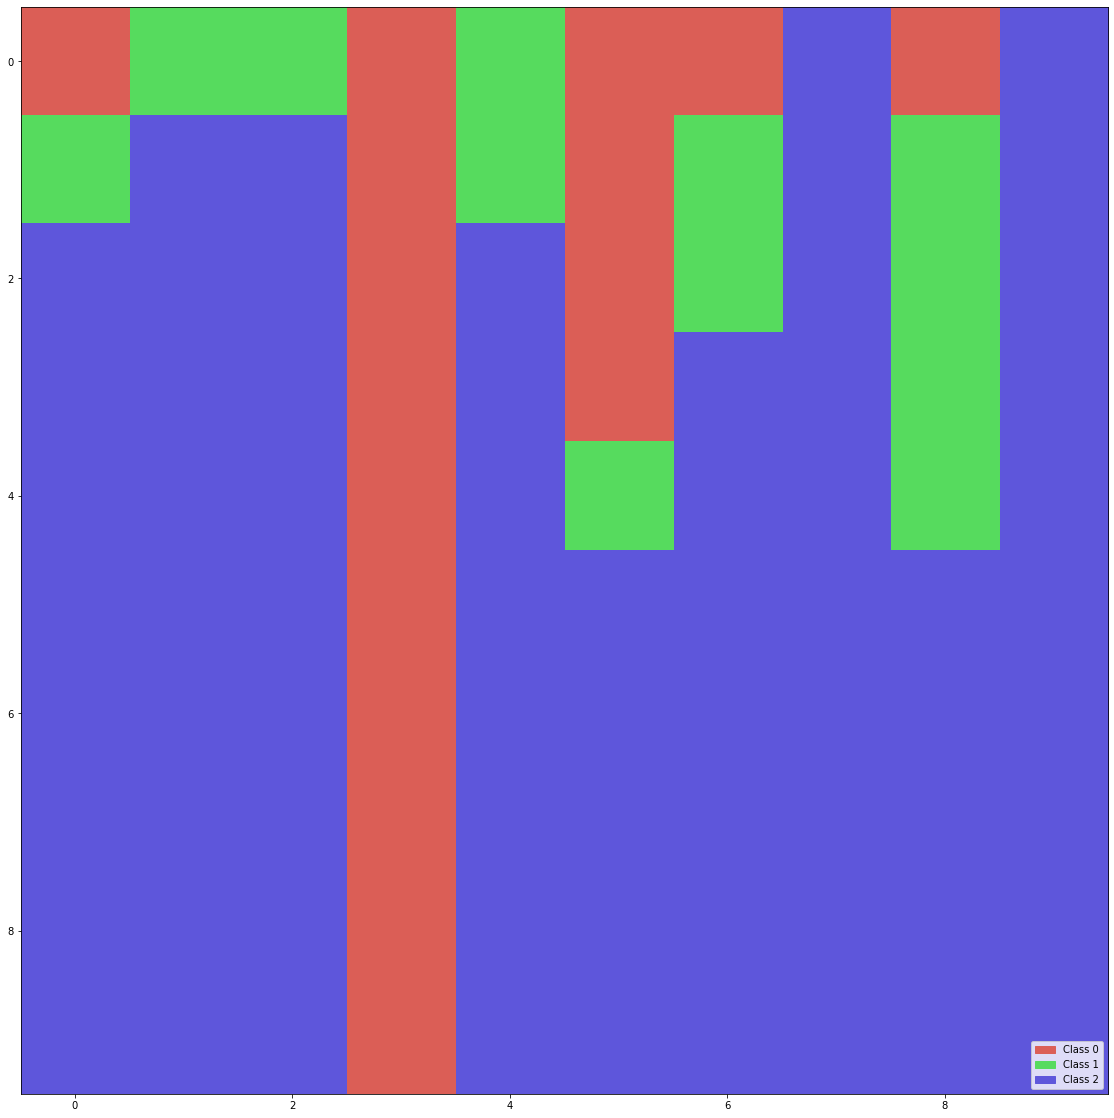

In [13]:
wave = np.ones((3, 10, 10))

wave_collapse_agorithm(wave, adj)

plt.figure()
plt.figure(figsize=(20,20))
show_state_map(wave)

(3, 3)
Iteration 0


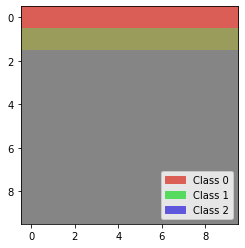

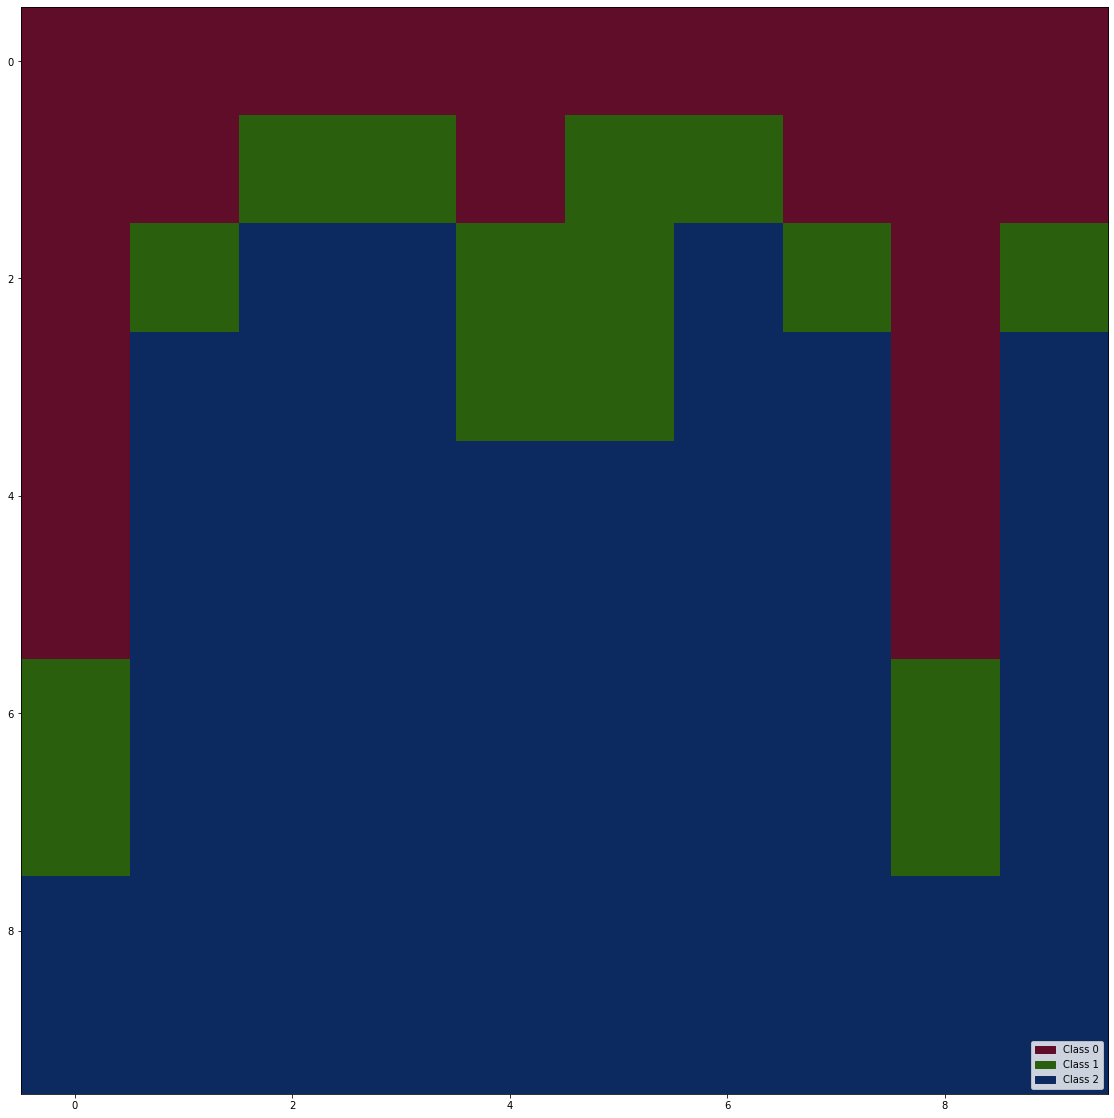

In [14]:

def build_vertical_rules(n_colors):
    
    bottom_rule = np.eye(n_colors)
    for i in range(n_colors - 1):
        bottom_rule[i + 1, i] = 1
        
    top_rule = np.eye(n_colors)
    for i in range(n_colors - 1):
        top_rule[i, i + 1] = 1
        
    side_rule = np.ones((n_colors, n_colors))
    
    return bottom_rule, top_rule, side_rule


def build_vertical_world(colors, size=10):
    
    # Define vars of the pb
    n_tiles = len(colors)
    wave = np.ones((n_tiles, size, size))

    # Build adjacency matric
    bottom_rule, top_rule, side_rule = build_vertical_rules(n_tiles)
    adj = {(-1, 0): bottom_rule, (1, 0): top_rule, (0, -1): side_rule, (0, 1): side_rule}
    
    print(bottom_rule.shape)

    # Define the bottom of the map as layer 0
    wave[1:, 0, :] = 0
    propagate(wave, adj)
    
    # Run the wave collapse alg
    wave_collapse_agorithm(wave, adj)

    plt.figure(figsize=(20,20))
    show_state_map(wave, colors)



build_vertical_world(COLORS)

(3, 3)
Iteration 0


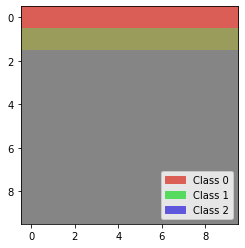

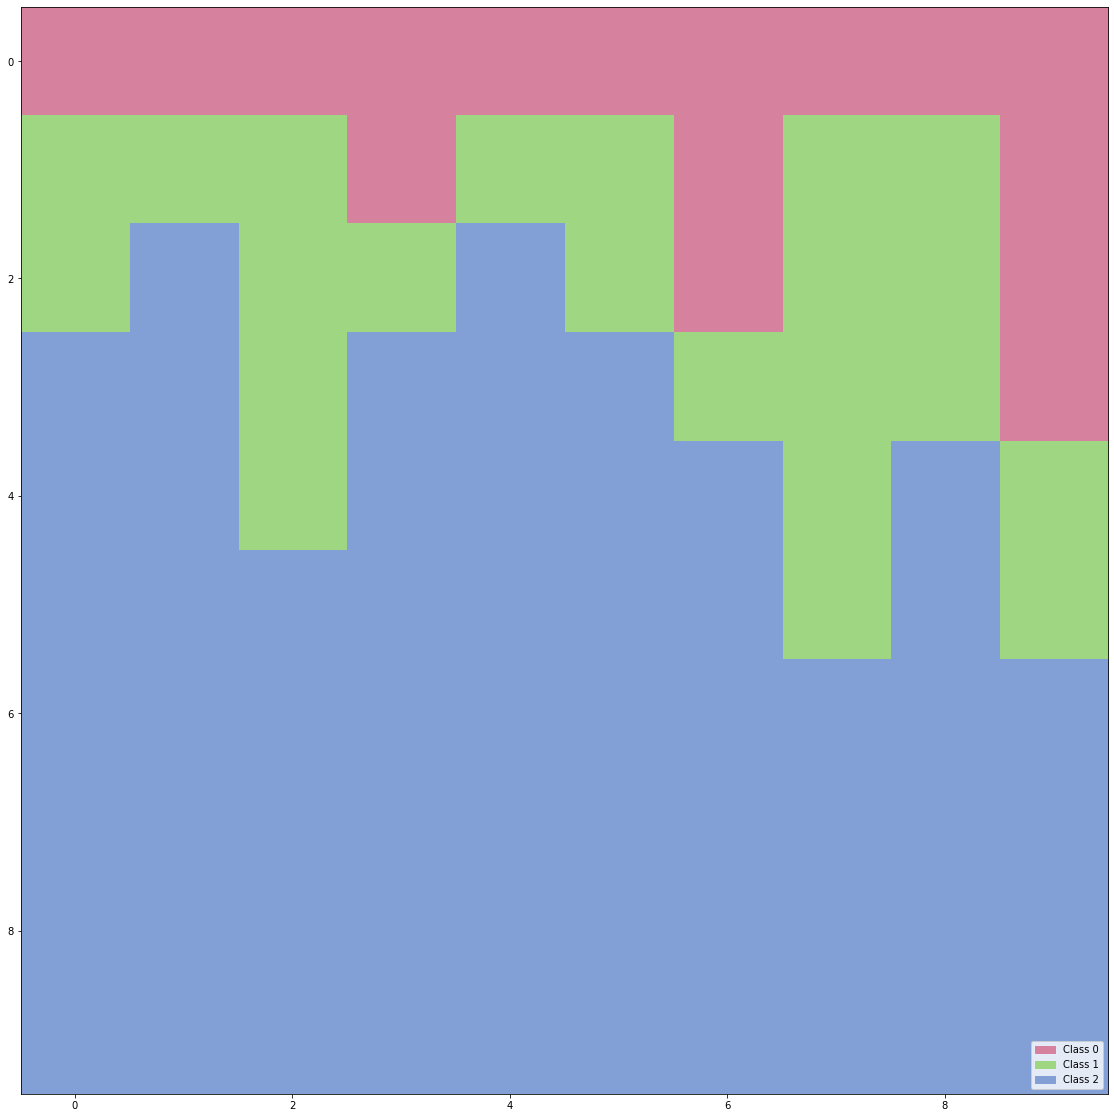

In [15]:

color_palette_build = lambda r,g,b: [(r, g, b), (b, r, g), (g, b, r)]

COLORS = color_palette_build(214, 130, 159)

build_vertical_world(COLORS)

(3, 3)
Iteration 0
Iteration 100


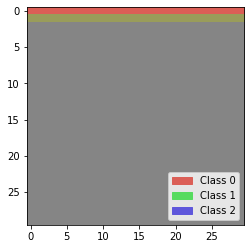

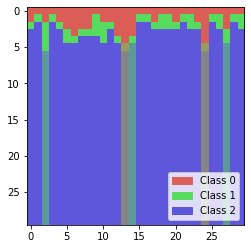

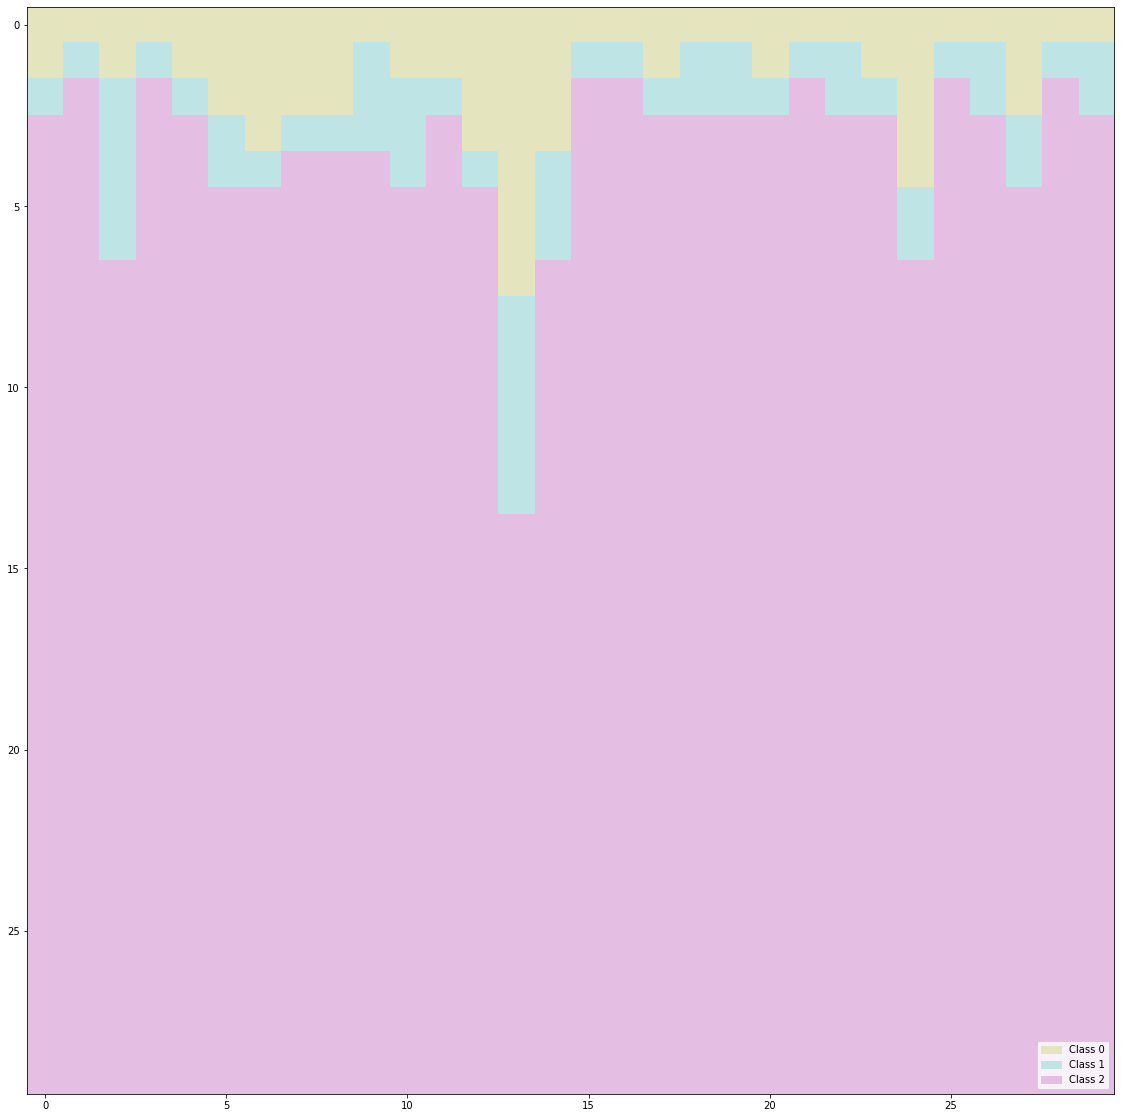

In [16]:

COLORS = color_palette_build(228, 229, 190)

build_vertical_world(COLORS, 30)

### A larger generation with multiple classes 

- Decreasing colors when the class index increases
- Larger nb of pixels for the page generation

[array([228., 229., 190.]), array([205., 206., 171.]), array([182., 183., 152.]), array([160., 160., 133.]), array([137., 137., 114.]), array([114., 114.,  95.]), array([91., 92., 76.]), array([68., 69., 57.]), array([46., 46., 38.]), array([23., 23., 19.])]
(10, 10)
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500
Iteration 1600
Iteration 1700


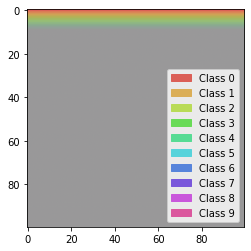

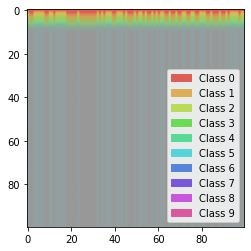

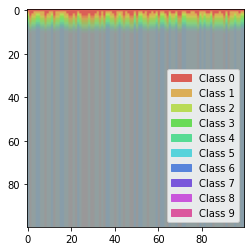

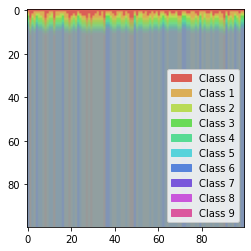

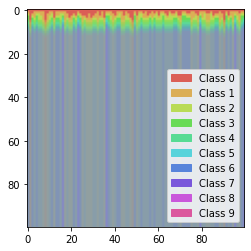

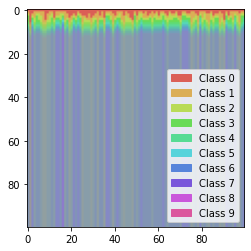

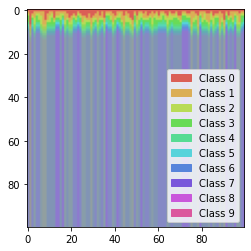

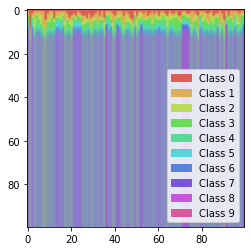

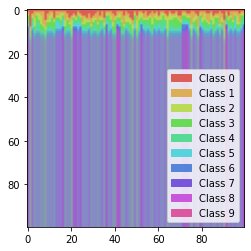

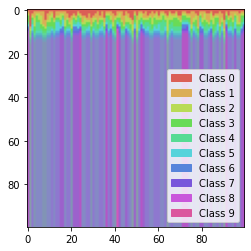

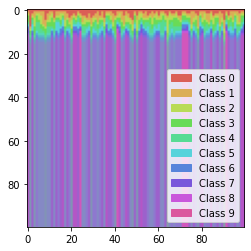

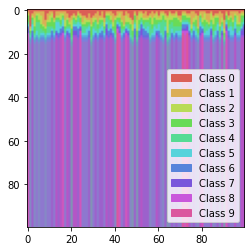

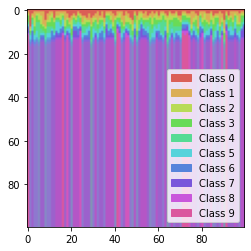

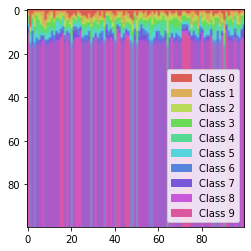

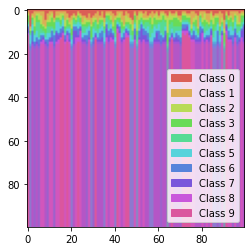

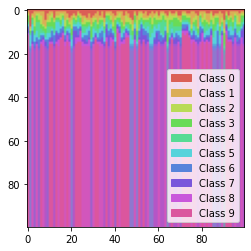

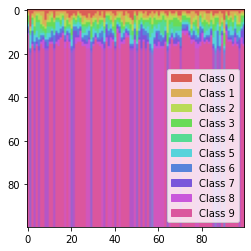

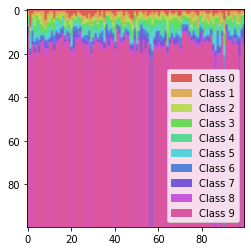

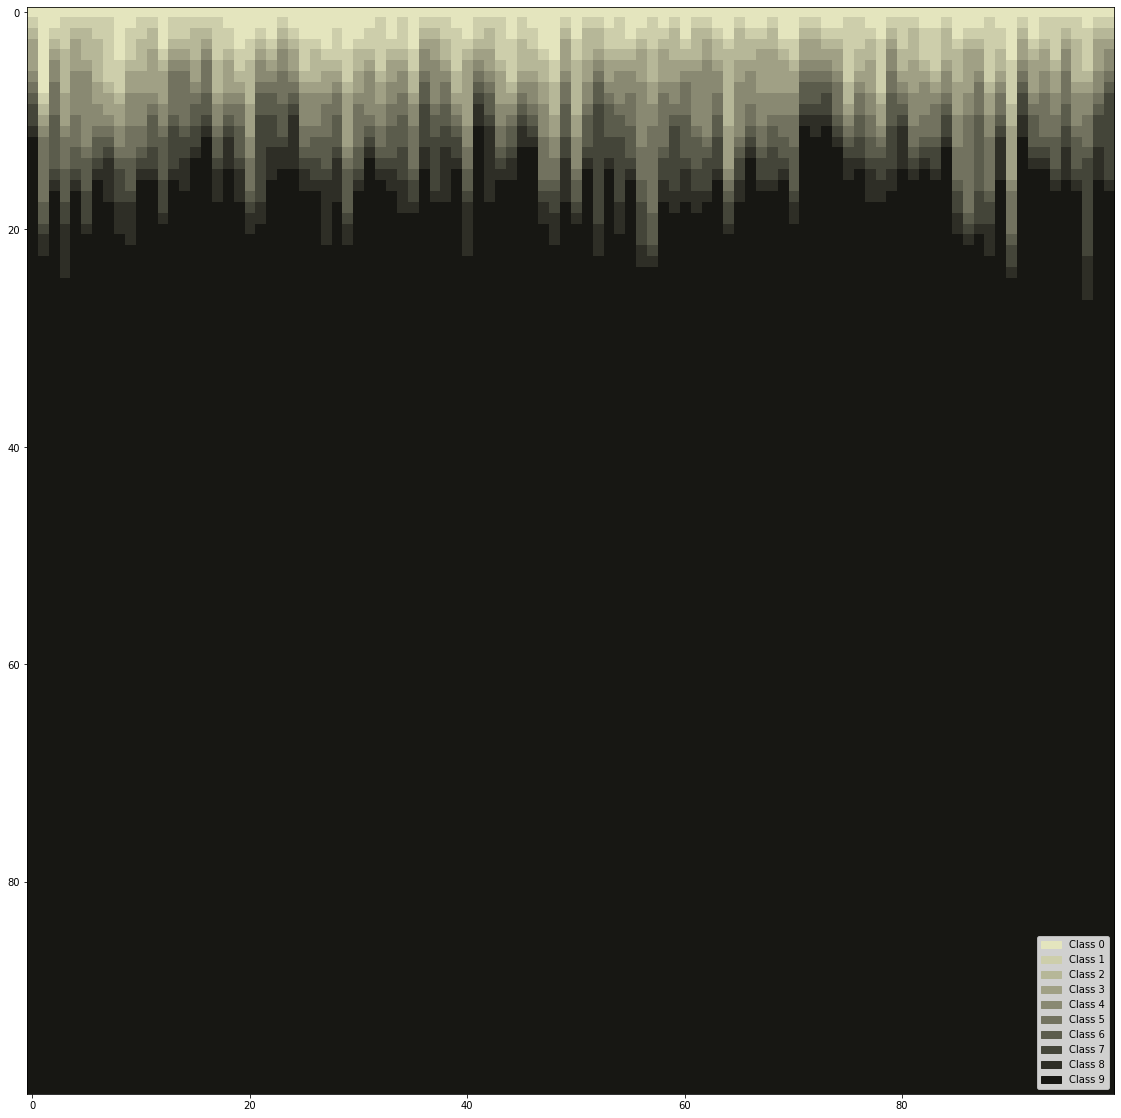

In [17]:

multiple_color_palette_build = lambda r,g,b, n: [np.round(float(n - i) / n * np.array([r, g, b])) for i in  range(n)]
my_colors = multiple_color_palette_build(228, 229, 190, 10)

print(my_colors)

build_vertical_world(my_colors, 100)

# 3 - Handling of symetry

This can be easily applied to domino-like tiles.
They need a matching number in order to be connected together.

Symmetry rules are defined on top of connected-or-not rules between tiles.
To simplify our example, we will keep only 1-0 connections
 
     up right down left 
T = \[0   1.    1.   1. \]

We can deduce connectivity of rotated version of T

       up right down left 
- T  = \[0   1.    1.   1. \]
- |- = \[1   1.    1.   0. \] rotated right once 90° 
- | =  \[1   1.    0.   1. \] rotated right twice 90° 
- -| = \[1   0.    1.   1. \] rotated right thrice 90° 


To find connections between symmetric transformation of peices we can use the following rule building : 

 - Right connection T and |-  == M\[0, right\] * M\[1, left\]



In [18]:

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

T_CONNECTIVITY = [0, 1, 1, 1]

ROT_90_MAT = np.array([[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0]])





In [19]:
ROT_90_MAT.dot(np.array(T_CONNECTIVITY))

array([1, 1, 1, 0])

In [20]:


def build_all_rotations(ref_pieces, keep=[1, 1, 1, 1]):
    assert type(ref_pieces) == list
    result_array = []
    for ref_piece in ref_pieces:
        result_array.append(ref_piece)
        for _, kept in zip(range(3), keep[1:]):
            if kept:
                result = ROT_90_MAT.dot(result_array[-1])
                result_array.append(result)
    return result_array


build_all_rotations([np.array(T_CONNECTIVITY)])


[array([0, 1, 1, 1]),
 array([1, 1, 1, 0]),
 array([1, 1, 0, 1]),
 array([1, 0, 1, 1])]

In [21]:
direction_dictionnary = {
    3: (-1, 0), 0: (-1, 0), 1: (0, 1), 3: (0, -1)
}

def build_adj_from_number_vec(vector_array):
    N = len(vector_array)
    adj = {direction: np.zeros((N, N)) for direction in direction_dictionnary.values()}
    for direction_index, direction in direction_dictionnary.items():
        for i in range(N):
            for j in range(N):
                adj[direction][i, j] = vector_array[i, direction_index] == vector_array[j, (direction_index + 2) % 4] 
    return adj
    
    
adj = build_adj_from_number_vec(np.array(build_all_rotations(np.array(T_CONNECTIVITY))))
adj

AssertionError: 

In [ ]:
wave = np.ones((4, 10, 10))

# Run the wave collapse alg
wave_collapse_agorithm(wave, adj)

plt.figure(figsize=(20,20))
show_state_map(wave, None)

In [ ]:
from skimage.transform import rotate

def buid_rotated_collection(pattern_size=40, img_path="/Users/a.morvan/Documents/code_dw/notebook_and_scripts_collections/wave_function_collapse/imgs/pipe/T_up.png"):
    pic = io.imread(img_path)  
    pic_resize = transform.resize(pic, (40, 40), anti_aliasing=True)
    pattern_map = dict()
    for index, angle in enumerate([0, 90, 180, 270]):
        pattern_map[index] = rotate(pic_resize, angle)   
        
    return pattern_map

pattern_map = buid_rotated_collection()
ffrom_wave_to_patterns(wave, pattern_map, 40)

In [ ]:
L_CONNECTIVITY = [1, 1, 0, 0]


array = np.array(build_all_rotations([np.array(T_CONNECTIVITY), np.array(L_CONNECTIVITY)]))

adj = build_adj_from_number_vec(array)


wave = np.ones((8, 10, 10))

# Run the wave collapse alg
excepted = True
count = 0
while excepted is True:
    try:
        wave_collapse_agorithm(wave, adj, show=False)
        excepted = False
    except:
        wave = np.ones((8, 10, 10))
        count += 1
        if count > 1000:
            break


#plt.figure(figsize=(20,20))
show_state_map(wave, None, legend=False)

pattern_map_1 = buid_rotated_collection(img_path="/Users/a.morvan/Documents/code_dw/notebook_and_scripts_collections/wave_function_collapse/imgs/pipe/gold_T_up.png")
pattern_map_2 = buid_rotated_collection(img_path="/Users/a.morvan/Documents/code_dw/notebook_and_scripts_collections/wave_function_collapse/imgs/pipe/gold_L_up.png")

for index, img in pattern_map_2.items():
    pattern_map_1[4 + index] = img


ffrom_wave_to_patterns(wave, pattern_map_1, 40)



# Handling more symetry with 1-to-many relation with tiles 

Challenges
- Not all symetries are needed for dot and I pattern, we need to to do it properly to reduce pb size
- Need to modify the pattern filling function to choose between two (or more) possible patterns

### Data structure

Dictionary like 

```
{L -> [rotated_matrices], X -> [...]}

adj, letter_to_index = build_adj_from_number_vec(...)
```

letter_to_index = {L_0°: 0, L_90°: 1, ...}

```
tiles = {L_0° -> [tile_1, tile_2], L_90° -> [tile_1_90 ..], X -> [X_up]}
build_patterns(wave, tiles`
```


### Handling Different symetries

In [ ]:


def build_symetry_set():

    # 4 elements created
    T_CONNECTIVITY = [0, 1, 1, 1]
    L_CONNECTIVITY = [1, 1, 0, 0]
    
    # 2 elements created
    I_CONNECTIVITY = [1, 0, 1, 0]
    
    # 1 element created
    X_CONNECTIVITY = [1, 1, 1, 1]
    ANTIX_CONNECTIVITY = [0, 0, 0, 0]

    array = np.array(build_all_rotations([np.array(T_CONNECTIVITY), np.array(L_CONNECTIVITY)]))
    array_2 = np.array(build_all_rotations([np.array(I_CONNECTIVITY)], keep=[1, 1, 0, 0]))

    final_array = np.concatenate([array, array_2, np.array(X_CONNECTIVITY).reshape((1, -1)), np.array(ANTIX_CONNECTIVITY).reshape((1, -1))], axis=0)
    
    index_dict = {f"T_{i}": i for i in range(4)}
    index_dict.update({f"L_{i}": j for i, j in enumerate(range(4, 8))})
    index_dict.update({f"I_{i}": j for i, j in enumerate(range(8, 10))})
    index_dict["X_0"] = 10
    index_dict["AX_0"] = 11
    
    array_dict = {k: final_array[v, :] for k, v in index_dict.items()}
    return array_dict, index_dict
    
def define_tile_set(tile_dict, array_dict):
    """
    We expect something like 
    tile_dict = {"T": ["file_1.jpg", "file_2.jpg"], ....}
    """
    found_letters = set(tile_dict.keys())
    sub_array = [array_dict[k].reshape(1, -1) for k in array_dict if k.split("_")[0] in found_letters]
    return np.concatenate(sub_array, axis=0) 


def run_wave_collapse(my_adj, h, w):
    n_tiles = my_adj[(-1, 0)].shape[0]
    wave = np.ones((n_tiles, h, w))

    # Run the wave collapse alg
    excepted = True
    count = 0
    while excepted is True:
        try:
            wave_collapse_agorithm(wave, my_adj, show=False)
            excepted = False
        except:
            wave = np.ones((n_tiles, h, w))
            count += 1
            if count > 1000:
                break
    return wave

def build_rotated_collection(tile_dict, index_dict, img_size=40):
    """
    tile_dict = {"T": ["file_1.jpg", "file_2.jpg"], ....}
    index_dict = {"T_0": 0, ..., "AX_0": 11}
    
    out: {0: [img1, img2], ...}
    """
    pattern_map = {k: list() for k in index_dict.values()}
    for tile_type, filepaths in tile_dict.items():
        for filepath in filepaths:
            pic = io.imread(filepath)
            pic_resized = transform.resize(pic, (img_size, img_size), anti_aliasing=True)
            for index, angle in enumerate([0, 90, 180, 270]):
                name = f"{tile_type}_{index}"
                if name in index_dict:
                    pattern_map[index_dict[name]].append(rotate(pic_resized, angle))
                
    return {k: v for k, v in pattern_map.items() if len(v) > 0}


def build_final_img(wave, pattern_map, pattern_size, ax=None):
    n_channels = pattern_map[0][0].shape[2]
    print("n_channels", [pattern_map[i][0].shape for i in range(len(pattern_map))])
    index_img = np.argmax(wave, axis=0)
    
    w = wave.shape[2] * pattern_size
    h = wave.shape[1] * pattern_size
    
    img = np.zeros((h, w, n_channels))
    
    for i in range(index_img.shape[0]):
        for j in range(index_img.shape[1]):
            index = int(index_img[i, j])
            tile_index = np.random.choice(range(len(pattern_map[index])))
            pattern = pattern_map[index][tile_index]
            img[i * pattern_size: (i+ 1) * pattern_size, j * pattern_size: (j+ 1) * pattern_size, :] = pattern
            
    if ax is None:
        plt.imshow(img)
    else:
        ax.imshow(img)



In [ ]:

tile_dict = {"T": ["/Users/a.morvan/Documents/code_dw/notebook_and_scripts_collections/wave_function_collapse/imgs/pipe/gold_T_up.png"],
             "L": ["/Users/a.morvan/Documents/code_dw/notebook_and_scripts_collections/wave_function_collapse/imgs/pipe/gold_L_up.png"]}
array_dict, index_dict = build_symetry_set()
array = define_tile_set(tile_dict, array_dict)
print(array)
adj = build_adj_from_number_vec(array)

wave = run_wave_collapse(adj, 10, 10)

pattern_map = build_rotated_collection(tile_dict, index_dict)



In [ ]:
plt.figure(figsize=(20,20))
build_final_img(wave, pattern_map, 40)

In [ ]:
dir_ = "/Users/a.morvan/Documents/code_dw/notebook_and_scripts_collections/wave_function_collapse/imgs"
tile_dict = {"T": [os.path.join(dir_, f) for f in ["racing/T_0_up.png"]],
             "L": [os.path.join(dir_, f) for f in ["racing/L_0_up.jpg"]],
             "I": [os.path.join(dir_, f) for f in ["racing/I_0_up.jpg"]],
             "X": [os.path.join(dir_, f) for f in ["racing/X_0.png"]],
             "AX": [os.path.join(dir_, f) for f in ["racing/AX_0.jpg"]],     }
array_dict, index_dict = build_symetry_set()
array = define_tile_set(tile_dict, array_dict)
print(array)
adj = build_adj_from_number_vec(array)
print(adj[(-1, 0)].shape)

wave = run_wave_collapse(adj, 10, 10)
print(wave.shape)


In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2)

pattern_map = build_rotated_collection(tile_dict, index_dict, img_size=80)
build_final_img(wave, pattern_map, 80, ax=ax1)

show_state_map(wave, ax=ax2)

In [ ]:
block_size = 100

plt.figure(figsize=(40,40))
pattern_map = build_rotated_collection(tile_dict, index_dict, img_size=block_size)
build_final_img(wave, pattern_map, block_size)

In [ ]:
for i, img in pattern_map.items():
    plt.figure()
    plt.imshow(img[0])
    plt.title(i)
    plt.legend()